# EDA

Preprocessed Dataset

In [41]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import Utils as U

In [42]:
# Load aggregated eICU patient table

paths = U.load_paths()

data_dir = paths['data_dir']
flat = pd.read_csv(data_dir + 'preprocessed_flat.csv')

time_series = pd.read_csv(data_dir + 'preprocessed_timeseries.csv')

patient = pd.read_csv('raw_agg_patient_table.csv')

flat.head()

ts_data = pd.merge(time_series, patient, how = 'left', left_on = 'patient', right_on = 'patientunitstayid').dropna()

ts_data.to_csv(data_dir + "new_timeseries_readyformodel.csv", index= False)

In [43]:
patient['patientunitstayid'] = patient['patientunitstayid'].astype(int)

In [44]:
time_series.head()

,patient,time,FiO2,bedside glucose,cvp,heartrate,noninvasivediastolic,noninvasivemean,noninvasivesystolic,respiration,...,respiration_mask,sao2_mask,st1_mask,st2_mask,st3_mask,systemicdiastolic_mask,systemicmean_mask,systemicsystolic_mask,temperature_mask,hour
0,141168,1,0.0,0.0,0.0,0.694915,0.000000,0.000000,0.000000,0.0,...,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.695652
1,141168,2,0.0,0.0,0.0,0.668079,0.244681,0.234513,0.156442,0.0,...,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.739130
2,141168,3,0.0,0.0,0.0,0.644068,0.244681,0.234513,0.156442,0.0,...,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.782609
3,141168,4,0.0,0.0,0.0,0.634181,0.244681,0.234513,0.156442,0.0,...,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.826087
4,141168,5,0.0,0.0,0.0,0.641243,0.244681,0.212389,0.156442,0.0,...,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.869565


In [45]:
data = pd.merge(time_series, flat.drop(columns = 'age'), how = 'left', left_on = 'patient', right_on = 'patient')

In [46]:
dup_cols = [c for c in patient.columns if c in data.columns]

In [47]:
categorical_cols = ['gender', 'age', 'ethnicity', 'apacheadmissiondx', 
                    'hospitaladmitsource', 'died','unittype', 'unitadmitsource',
                    'unitstaytype', 'intubated','aids', 'vent', 'dialysis',
                    'lymphoma', 'immunosuppression', 'diabetes', 
                    'numbedscategory', 'teachingstatus', 'hospitalregion']

for col in categorical_cols:
    patient[col] = patient[col].astype('category')

In [48]:
data = pd.merge(data, patient.drop(columns = dup_cols), how = 'left', left_on = 'patient', right_on = 'patientunitstayid')

In [49]:
# drop_cols = ['']

# data.to_csv(data_dir + "preprocessed_total.csv")

In [50]:
# test = data.dropna()



In [51]:
# test.died.describe()

# test.to_csv(data_dir + 'clean_preprocessed_total.csv', index= False)

# patient = test

### Distribution of numeric variables

In [52]:
# patient_num_vars = data.select_dtypes(include=np.number)
# num_vars_to_exclude = ['patientunitstayid', 'patienthealthsystemstayid', 
#                        'wardid']
# num_cols_to_keep = [col for col in patient_num_vars.columns if 
#                     col not in(num_vars_to_exclude)]
# patient_num_vars = patient_num_vars.loc[:, num_cols_to_keep]

In [53]:
# pd.set_option('display.max_columns', None)
# patient_num_vars.describe()

There are several variables related to the APACHE score that have a minimum value of -1. We assume that these values are missing so we will recode these as null.

In [54]:
cols_to_recode = ['urine', 'wbc', 'temperature', 'respiratoryrate', 'sodium',
                  'heartrate', 'meanbp', 'ph', 'creatinine', 'albumin', 
                  'glucose', 'bilirubin', 'fio2', 'pao2', 'pco2', 'bun', 
                  'meanapachescore', 'meanpredictedicumortality', 
                  'meanpredictediculos']

for col in cols_to_recode: 
    data.loc[data[col] == -1, col] = np.nan

### Distribution of categorical features

In [55]:
# Define function to get categorical percentages for categorical variables
def get_categorical_percentages(df):
    """
    This function computes the percentages of categories for each categorical
    variable in the data.
    
    :param df: data
    :type df: pandas dataframe
    
    :return: prints each variable with their categories and respective 
    proportions
    """
    cat_df = df.select_dtypes(include='category')
    for var in cat_df.columns:
        perc = df[var].value_counts(normalize=True)
        print(var)
        print(perc)

In [56]:
data.age = data.age.astype('category')

In [57]:
# Recode age, teaching status and gender variables
data.age = data.age.cat.rename_categories({'> 89': 90})
data.age = pd.to_numeric(data.age, errors='coerce')

data['age0-9'] = np.nan
data.loc[(data.age >= 0) & (data.age <= 9), 'age0-9'] = 1
data.loc[(data.age > 9), 'age0-9'] = 0
data['age0-9'] = data['age0-9'].astype('category')

data['age10-19'] = np.nan
data.loc[(data.age >= 10) & (data.age <= 19), 'age10-19'] = 1
data.loc[(data.age > 19), 'age10-19'] = 0
data['age10-19'] = data['age10-19'].astype('category')

data['age20-29'] = np.nan
data.loc[(data.age >= 20) & (data.age <= 29), 'age20-29'] = 1
data.loc[(data.age > 29), 'age20-29'] = 0
data['age20-29'] = data['age20-29'].astype('category')

data['age30-39'] = np.nan
data.loc[(data.age >= 30) & (data.age <= 39), 'age30-39'] = 1
data.loc[(data.age > 39), 'age30-39'] = 0
data['age30-39'] = data['age30-39'].astype('category')

data['age40-49'] = np.nan
data.loc[(data.age >= 40) & (data.age <= 49), 'age40-49'] = 1
data.loc[(data.age > 49), 'age40-49'] = 0
data['age40-49'] = data['age40-49'].astype('category')

data['age50-59'] = np.nan
data.loc[(data.age >= 50) & (data.age <= 59), 'age50-59'] = 1
data.loc[(data.age > 59), 'age50-59'] = 0
data['age50-59'] = data['age50-59'].astype('category')

data['age60-69'] = np.nan
data.loc[(data.age >= 60) & (data.age <= 69), 'age60-69'] = 1
data.loc[(data.age > 69), 'age60-69'] = 0
data['age60-69'] = data['age60-69'].astype('category')

data['age70-79'] = np.nan
data.loc[(data.age >= 70) & (data.age <= 79), 'age70-79'] = 1
data.loc[(data.age > 79), 'age70-79'] = 0
data['age70-79'] = data['age70-79'].astype('category')

data['age80-89'] = np.nan
data.loc[(data.age >= 80) & (data.age <= 89), 'age80-89'] = 1
data.loc[(data.age > 89), 'age80-89'] = 0
data['age80-89'] = data['age80-89'].astype('category')

data['age>89'] = np.nan
data.loc[(data.age > 89), 'age>89'] = 1
data.loc[(data.age <= 89), 'age>89'] = 0
data['age>89'] = data['age>89'].astype('category')
data.drop(columns='age', inplace=True)

data.teachingstatus = np.where(data.teachingstatus == 't', 1, 0)
data.teachingstatus = data.teachingstatus.astype('category')

data['gendermale'] = np.nan
data.loc[data.gender == 'Male', 'gendermale'] = 1
data.loc[data.gender == 'Female', 'gendermale'] = 0
data.gendermale = data.gendermale.astype('category')
data.drop(columns='gender', inplace=True)

In [58]:
get_categorical_percentages(data)

hospitaladmitsource
Emergency Department    0.508096
Floor                   0.211850
Operating Room          0.076178
Direct Admit            0.075074
Step-Down Unit (SDU)    0.033734
Acute Care/Floor        0.031771
Recovery Room           0.027478
Other Hospital          0.022571
PACU                    0.007360
Other ICU               0.003557
Chest Pain Center       0.001104
ICU to SDU              0.000736
ICU                     0.000245
Observation             0.000245
Other                   0.000000
Name: hospitaladmitsource, dtype: float64
died
0.0    0.869632
1.0    0.130368
Name: died, dtype: float64
aids
0.0    0.998087
1.0    0.001913
Name: aids, dtype: float64
lymphoma
0.0    0.994739
1.0    0.005261
Name: lymphoma, dtype: float64
immunosuppression
0.0    0.961645
1.0    0.038355
Name: immunosuppression, dtype: float64
diabetes
0.0    0.816356
1.0    0.183644
Name: diabetes, dtype: float64
numbedscategory
>= 500       0.425620
250 - 499    0.251837
100 - 249    0.250559

There are a few features with highly skewed distributions towards one category over the other (99% vs 1%) including `aids` and `lymphoma`. We will drop these features,`apacheadmissiondx` given that there are a lot of categories for this feature, and `unitstaytype` since it is similar to the `hospitaladmitsource` variable.

In [59]:
data.drop(columns=['aids', 'lymphoma', 'unitstaytype'], inplace=True)

In [60]:
# One hot encode categorical variables
categorical_df = data.select_dtypes(include='category')
cols_to_encode = [col for col in categorical_df.columns 
                  if categorical_df[col].nunique() > 2]
ind_vars = pd.get_dummies(categorical_df.loc[:, cols_to_encode])
ind_vars = ind_vars.apply(lambda x: x.astype('category'))

# Remove hospital region from list of columns to drop because it will be used 
# for stratified sampling later
cols_to_encode.remove('hospitalregion')

data = data.drop(columns=cols_to_encode)
data = pd.concat([data, ind_vars], axis=1)

### Visualize numeric variables by target

In [61]:
# num_df = data.select_dtypes(include=np.number)
# num_vars_to_exclude = ['patientunitstayid', 'patienthealthsystemstayid', 
#                        'wardid', 'hospitalid']
# num_cols_to_keep = [col for col in num_df.columns if 
#                     col not in(num_vars_to_exclude)]
# num_df = num_df.loc[:, num_cols_to_keep]
# num_df['died'] = data['died']

# fig=plt.figure(figsize=(15,70))
# variables = num_df.columns.drop('died')
# for i, var in enumerate(variables):
#     ax=fig.add_subplot(35, 4, i+1)
#     ax=plt.gca()
#     num_df.boxplot(column=var,
#                    by='died', 
#                    grid=False, 
#                    ax=ax)
#     ax.set(ylabel=var)
#     ax.set_title(var)
# fig.suptitle('')
# fig.tight_layout()
# plt.show()


### Distribution of categorical variables by target

In [62]:
# Get proportions of target for each categorical variable
categorical_df = data.select_dtypes(include='category')
variables = categorical_df.columns.drop('died')  
for var in variables:
    print(pd.crosstab(categorical_df[var], 
                      categorical_df['died'], 
                      normalize='columns'), "\n")

died                    0.0       1.0
immunosuppression                    
0.0                0.964914  0.939839
1.0                0.035086  0.060161 

died           0.0       1.0
diabetes                    
0.0       0.814342  0.829787
1.0       0.185658  0.170213 

died                 0.0      1.0
teachingstatus                   
0               0.714144  0.70653
1               0.285856  0.29347 

died                 0.0       1.0
hospitalregion                    
Midwest         0.348394  0.275285
Northeast       0.101720  0.122433
South           0.404472  0.459316
West            0.145413  0.142966 

died        0.0  1.0
age0-9              
0.0     0.99989  1.0
1.0     0.00011  0.0 

died           0.0  1.0
age10-19               
0.0       0.994719  1.0
1.0       0.005281  0.0 

died           0.0       1.0
age20-29                    
0.0       0.965163  0.988995
1.0       0.034837  0.011005 

died           0.0       1.0
age30-39                    
0.0       0.952905

There seems to be a significant difference in the proportion of patients who died between the categories of all categorical variables except gender and patients age 70-79.

### Mortality by discharge time

In [63]:
data.hospitaldischargetime24 = pd.to_datetime(data.hospitaladmittime24, format='%H:%M:%S')
data['hospitaldischargetimehr'] = data.hospitaldischargetime24.dt.hour

In [64]:
temp = data.copy()
temp['died'] = pd.to_numeric(temp['died'], errors='coerce')

discharge_hour_mortality = (
    temp.groupby('hospitaldischargetimehr')
        .agg(total=pd.NamedAgg(column='died', aggfunc='count'), 
             mortalitycount=pd.NamedAgg(column='died', aggfunc='sum'))
)
discharge_hour_mortality = (
    discharge_hour_mortality.assign(
        mortalityrate=(discharge_hour_mortality['mortalitycount'] / 
                       discharge_hour_mortality['total'])
    )
)
discharge_hour_mortality = discharge_hour_mortality.reset_index()

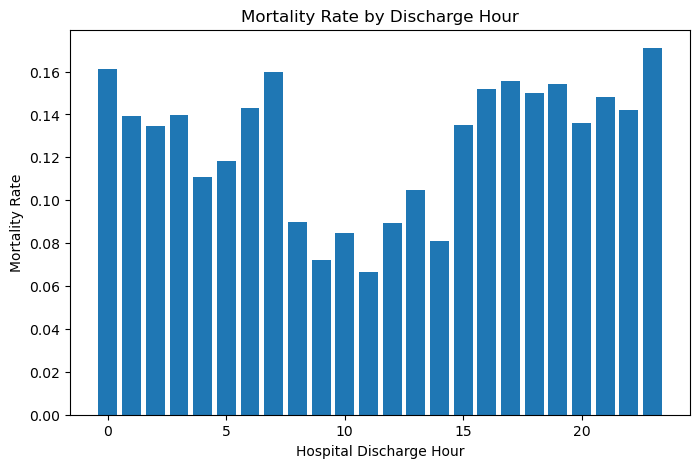

In [65]:
fig = plt.figure(figsize = (8, 5))
plt.bar(discharge_hour_mortality.hospitaldischargetimehr, 
        discharge_hour_mortality.mortalityrate)
plt.xlabel('Hospital Discharge Hour')
plt.ylabel('Mortality Rate')
plt.title('Mortality Rate by Discharge Hour')
plt.show()

In [66]:
# Create indicator variable that indicates the timespan covering the drop
# in mortality rate from hours 8 to 14.
data['dischargehour8-14'] = (
    np.where((data.hospitaldischargetimehr >= 8) & 
             (data.hospitaldischargetimehr <= 14), 1, 0)
)

data.drop(columns=['hospitaladmittime24', 'hospitaldischargetime24', 
                      'unitadmittime24', 'unitdischargetime24', 
                      'hospitaldischargetimehr'], inplace=True)

### Check for missing values

We will exclude any columns with more than 50% missing values and impute the other columns that do not exceed this threshold. However, we will first remove all patients who have a missing discharge status.

In [67]:
data.died.isna().sum()

1888032

In [68]:
data.dropna(subset='died', inplace=True)
data.shape

(250920, 360)

In [69]:
missing_val_count = data.isna().sum()
missing_df = pd.DataFrame(data={'variable': data.columns, 
                                'missing_val_count': missing_val_count.values})
missing_df['missing_val%'] = (
    100 * (missing_df['missing_val_count'] / patient.shape[0])
)

# Get columns with more than 80% missing data
cols_to_drop = (
    missing_df.loc[missing_df['missing_val%'] >= 80, 'variable'].tolist()
)

data.drop(columns=cols_to_drop, inplace=True)

We will impute the numeric variables with the median and categorical variable with the most frequent label. Before doing so, we will first split the data into training and testing to avoid data leakage.

### Train-Test Split

We will randomize our train and test sets by patient and use stratified sampling by `hospitalregion` and `teachingstatus` to ensure that the distribution of patients from different regions and whether the hospital they are in is a teaching hospital are equivalent between the training and test data sets.

In [70]:
# Drop missing values by variables that will be used for stratified sampling
data.dropna(subset=['hospitalregion', 'teachingstatus'], inplace=True)
print(data.shape)
print(data.uniquepid.nunique())

# Remove irrelevant columns
data.drop(columns=['patientunitstayid', 'patienthealthsystemstayid', 
                      'wardid', 'uniquepid'], 
             inplace=True)


X = data.drop(columns=['died', 'hospitalid'])
y = data.died
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    stratify=X[['hospitalregion',
                                                                'teachingstatus']],
                                                    random_state=607)

print(X_train.shape)
print(X_test.shape)

(240840, 265)
10035
(192672, 259)
(48168, 259)


##### Sanity check for stratified sampling

In [71]:
print(X_train.teachingstatus.value_counts(normalize=True))
print(X_test.teachingstatus.value_counts(normalize=True))

0    0.701145
1    0.298855
Name: teachingstatus, dtype: float64
0    0.70115
1    0.29885
Name: teachingstatus, dtype: float64


In [72]:
print(X_train.hospitalregion.value_counts(normalize=True))
print(X_test.hospitalregion.value_counts(normalize=True))

# Drop hospital region column 
X_train.drop(columns='hospitalregion', inplace=True)
X_test.drop(columns='hospitalregion', inplace=True)

South        0.411658
Midwest      0.338814
West         0.145096
Northeast    0.104431
Name: hospitalregion, dtype: float64
South        0.411663
Midwest      0.338814
West         0.145076
Northeast    0.104447
Name: hospitalregion, dtype: float64


### Impute missing values

In [73]:
# Impute numeric variables with median
numeric_vars = X_train.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='median')
imputer = imputer.fit(X_train[numeric_vars])
X_train[numeric_vars] = imputer.transform(X_train[numeric_vars])
X_test[numeric_vars] = imputer.transform(X_test[numeric_vars])

In [74]:
# Impute categorical variables with most frequent label
categorical_vars = X_train.select_dtypes(include='category').columns
imputer = SimpleImputer(strategy='most_frequent')
imputer = imputer.fit(X_train[categorical_vars])
X_train[categorical_vars] = imputer.transform(X_train[categorical_vars])
X_test[categorical_vars] = imputer.transform(X_test[categorical_vars])

In [75]:
X_train.isna().sum().sum()

2768

In [76]:
X_test.isna().sum().sum()

736

In [77]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

print(train.shape)
print(test.shape)

# Save training and test datasets to csv 
train.to_csv(data_dir + 'train.csv', index=False)
test.to_csv(data_dir + 'test.csv', index=False)

(192672, 259)
(48168, 259)
